In [8]:
%load_ext autoreload
%autoreload 2

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = 'all'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import numpy as np
import json
from random import sample

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

In [10]:
import torch
import torch.nn.functional as F

from transformers import *

In [11]:
models = {}

In [12]:
model_class, tokenizer_class, shortcut, mask_token = RobertaForMaskedLM, RobertaTokenizer, 'roberta-base', '<mask>'
model, tokenizer = model_class.from_pretrained(shortcut), tokenizer_class.from_pretrained(shortcut)
models[shortcut] = (model, tokenizer, mask_token)

Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at roberta-base and are newly initialized: ['lm_head.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
model_class, tokenizer_class, shortcut, mask_token = RobertaForMaskedLM, RobertaTokenizer, 'roberta-large', '<mask>'
model, tokenizer = model_class.from_pretrained(shortcut), tokenizer_class.from_pretrained(shortcut)
models[shortcut] = (model, tokenizer, mask_token)

Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at roberta-large and are newly initialized: ['lm_head.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [78]:
model_class, tokenizer_class, shortcut, mask_token = GPT2LMHeadModel, GPT2Tokenizer, 'gpt2', None
model, tokenizer = model_class.from_pretrained(shortcut), tokenizer_class.from_pretrained(shortcut)
models[shortcut] = (model, tokenizer, mask_token)

In [21]:
model_class, tokenizer_class, shortcut, mask_token = GPT2LMHeadModel, GPT2Tokenizer, 'gpt2-large', None
model, tokenizer = model_class.from_pretrained(shortcut), tokenizer_class.from_pretrained(shortcut)
models[shortcut] = (model, tokenizer, mask_token)

In [48]:
model_class, tokenizer_class, shortcut, mask_token = GPT2LMHeadModel, GPT2Tokenizer, 'gpt2-xl', None
model, tokenizer = model_class.from_pretrained(shortcut), tokenizer_class.from_pretrained(shortcut)
models[shortcut] = (model, tokenizer, mask_token)

In [14]:
model, tokenizer, mask_token = models['roberta-large']

In [15]:
import re
import pandas as pd
import collections
import os
import nltk

In [216]:
# # 处理因果关系->causes_dict
# DiffVec
filename = 'diffvec_word_pairs_final.SEMBLESS.csv'
file_colname=['relation','word1','word2']
df = pd.read_csv(filename,header=None,names=file_colname)
df = df[df['relation'].str.contains('CAUSE')]
#df

# 为每一种 CAUSE 创建一个句式
# 为各个类型创建字典
effect = {}
action_goal = {}
enablingAgent_object = {}
prevention = {}
agent_goal = {}
instrument_goal = {}
compensatory_action = {}
instrument = {}

cause_class = {
    'CAUSE-PURPOSE$Cause:Effect':effect,
    'CAUSE-PURPOSE$Action/Activity:Goal':action_goal,
    'CAUSE-PURPOSE$EnablingAgent:Object':enablingAgent_object,
    'CAUSE-PURPOSE$Prevention':prevention,
    'CAUSE-PURPOSE$Agent:Goal':agent_goal,
    'CAUSE-PURPOSE$Instrument:Goal':instrument_goal,
    'CAUSE-PURPOSE$Cause:CompensatoryAction':compensatory_action,
    'CAUSE-PURPOSE$Instrument:IntendedAction':instrument
}


for index, row in df.iterrows():
    # 先判断是否是已经存在的 key
    if (row['word1'] in cause_class[row['relation']].keys()):
        cause_class[row['relation']][row['word1']].append(row['word2'])
    else:
        cause_class[row['relation']][row['word1']] = [row['word2']]

result_dict = {}
for key,value in cause_class.items():
    result_dict.update(value)
#print(result_dict)
print(cause_class['CAUSE-PURPOSE$Action/Activity:Goal'])

{'advertise': ['promote'], 'assault': ['injure'], 'bathe': ['clean'], 'breathe': ['live'], 'burnish': ['shine'], 'buy': ['own'], 'cook': ['eat'], 'drive': ['arrive'], 'exercise': ['healthy'], 'fight': ['defend', 'win'], 'flirt': ['seduce'], 'ignite': ['burn'], 'jog': ['exercise'], 'learn': ['study'], 'light': ['illumination'], 'listen': ['enjoy', 'hear'], 'play': ['enjoy'], 'purchase': ['possess'], 'reach': ['hold'], 'read': ['know', 'learn'], 'run': ['exercise'], 'shoot': ['kill'], 'shop': ['purchase'], 'sleep': ['rest'], 'spank': ['punish'], 'speak': ['communicate', 'express'], 'starving': ['hungry'], 'steal': ['gain'], 'study': ['learn'], 'trim': ['shorten'], 'wash': ['clean'], 'work': ['earn']}


In [182]:
# 把dict的词替换到句子模板
templates = {
    'CAUSE-PURPOSE$Cause:Effect':'* _ causes * = .',
    'CAUSE-PURPOSE$Action/Activity:Goal':'* _ leads to * = .',
    'CAUSE-PURPOSE$EnablingAgent:Object':'Without * _ , * = can not work .',
    'CAUSE-PURPOSE$Prevention':'* _ can prevent * = .',
    'CAUSE-PURPOSE$Agent:Goal':'The goal of * _ is * = .',
    'CAUSE-PURPOSE$Instrument:Goal':'The goal of * _ is to provide * = .',
    'CAUSE-PURPOSE$Cause:CompensatoryAction':'* _ can be relieved by * = .',
    'CAUSE-PURPOSE$Instrument:IntendedAction':'A * _ is used to * = .'
}

texts = []

data = cause_class['CAUSE-PURPOSE$Action/Activity:Goal']
one = templates['CAUSE-PURPOSE$Action/Activity:Goal']
for (key,value) in data.items():
        #print(key,value)
        #print('=========================================')
    for word in value:
            example = one.replace('_', key).replace('=', word)
            texts.append(example)
        
print(len(texts))


36


In [183]:
# 得到attention值
all_attn_probs, idx_pairs, tokenses = [], [], []
for text in tqdm(texts):
    if mask_token is not None:
        text = text.replace(' _ ', ' %s ' % mask_token)
    tokens = tokenizer.convert_ids_to_tokens(tokenizer.encode(text, add_special_tokens=True))
    tokens = ['*' if token in ['*', 'Ġ*'] else token for token in tokens]
    marker = '*'
    if marker in tokens:
        assert tokens.count(marker) == 2, str(tokens)
        p, h = [i for i, token in enumerate(tokens) if token == marker]
        tokens = [token for token in tokens if token != marker]
        h -= 1
        #print(tokens[p], tokens[h])
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    pred_idx = [i for i, token in enumerate(tokens) if token == mask_token] if mask_token is not None else [-1]
    tokens = ['@' + token if not token.startswith('Ġ') and token not in ['<s>', '</s>', '<mask>'] else token.replace('Ġ', '') 
              for token in tokens] 
    #print(tokens)
    
    input_ids = torch.tensor([token_ids])
    with torch.no_grad():
        logits, attns = model(input_ids, output_attentions=True)
        probs = F.softmax(logits, dim=-1)

    attn_scores, attn_probs = zip(*attns)
    attn_scores, attn_probs = torch.cat(attn_scores, dim=0), torch.cat(attn_probs, dim=0)
    all_attn_probs.append(attn_probs)
    idx_pairs.append((p, h))
    tokenses.append(tokens)
    #print("===============================")
   # print(tokenses)
    #print(idx_pairs)
    #print(attn_probs[0, 0, 1, 1])
   # print(attn_probs[:, :, h, p])

# 求注意力值的平均值
attn_sum = np.zeros((24, 16),dtype='float32')
i = 0
for attn_one, (p, h) in zip(all_attn_probs, idx_pairs):    
    attn_every = np.array(attn_one[:, :, h, p])
   #求和
    attn_sum += attn_every
   # 记录总共有多少句子来求平均
    i = i+1
#sum = attn_sum.tolist()
#求平均
attn_average = attn_sum/i
average = attn_average.tolist()
#print(average)

100%|██████████| 36/36 [00:02<00:00, 12.20it/s]


Text(0.5, 33.0, 'Average-cause-head')

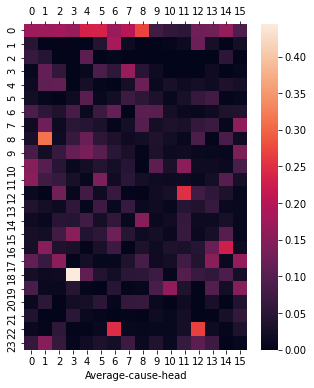

In [212]:
# 算平均后的head图
fig = plt.subplots(1,1,sharey=False, figsize=(5 , 6))
ax = sns.heatmap(attn_average)
ax.tick_params(top=True, labeltop=True)
ax.set_xlabel('Average-cause-head')

<AxesSubplot:>

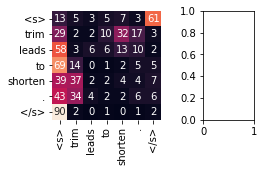

In [211]:
i =33
layer, head = 18, 3
attn = all_attn_probs[i][layer, head]
tokens = tokenses[i]
size = round(attn.size(0) / 3)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(size  * 2., size), gridspec_kw={'width_ratios': [3, 1]})
sns.heatmap((attn * 100).long(), square=True, cbar=False, annot=True, fmt='d', xticklabels=tokens, yticklabels=tokens, ax=ax0)
 